In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Fixed trigger

Use an exponential decay in time, and Gaussian in space, and see what background we can fit to the Chicago data.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_fixed
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.naive

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

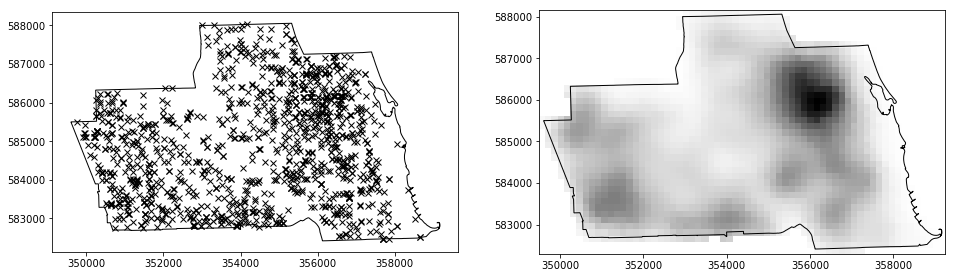

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

# Train

In [16]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
trainer = sepp.sepp_fixed.GridTrainer(grid, tk, sk)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

GridModel(mu size=(39, 65), T=365.9583333333333, theta=0.04459466982938563, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50))

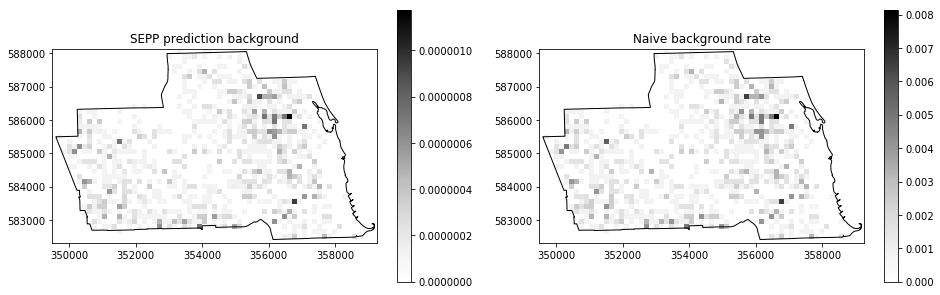

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

ax = axes[0]
pred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("SEPP prediction background")

naive = open_cp.naive.CountingGridKernel(grid.xsize, grid.ysize, grid.region())
naive.data = points
pred = naive.predict().renormalise()
ax = axes[1]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("Naive background rate")

None

### Speed of convergence

In [23]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
trainer = sepp.sepp_fixed.GridTrainer(grid, tk, sk)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(100):
    opt = trainer._optimiser(model, data)
    old_model = model
    model = opt.iterate()
    print(model, np.mean((model.mu - old_model.mu)**2), (model.theta - old_model.theta)**2)

GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.1325057086339578, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 2.72573377242e-16 0.135052054187
GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.10257446102574173, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 1.44828528601e-17 0.000895879583384
GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.09212512778217709, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 2.10924535731e-18 0.000109188565235
GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.08760390698667032, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 4.4765007079e-19 2.04414374817e-05
GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.08543821484996043, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 1.16064012569e-19 4.69022243101e-06
GridModel(mu size=(39, 65), T=730.9583333333334, theta=0.08434677711551886, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)) 3.2

## Dependence on parameters

In [24]:
omegas = np.linspace(0.01, 1, 100)
models = dict()
for omega in omegas:
    tk = sepp.sepp_fixed.ExpTimeKernel(omega)
    sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
    trainer = sepp.sepp_fixed.GridTrainer(grid, tk, sk)
    trainer.data = points
    models[omega] = trainer.train(datetime.datetime(2017,1,1), iterations=20)

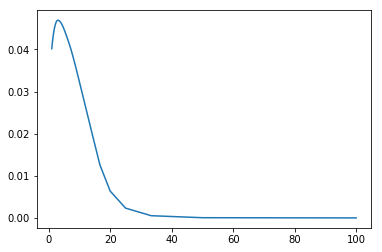

In [27]:
plt.plot([1/om for om in omegas], [models[om].theta for om in omegas])